In [ ]:
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

In [1]:
from groundingdino.util.inference import load_model, load_image, predict, annotate
import cv2

from torchvision.ops import box_convert
from ultralytics.utils.metrics import ConfusionMatrix, Metric
from diffusers import StableDiffusionInpaintPipeline

import torch
from PIL import Image
import numpy as np
import logging
import base64
from functools import partial
import io
import json
import random
from torchvision.ops import box_convert
from torchvision.transforms import ToPILImage
import re
from io import BytesIO
import tempfile

In [2]:
model = load_model("../GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", "groundingdino_swint_ogc.pth")

final text_encoder_type: bert-base-uncased


In [3]:
image_source, image = load_image("perrito.jpeg")

In [4]:
prompt = "a hat"

In [5]:
boxes, logits, phrases = predict(
        model=model,
        image=image,
        caption=prompt,
        box_threshold=0.3,
        text_threshold=0.1,
        device='cpu'
    )

In [6]:
H, W, _ = image_source.shape
print("H: %d, W: %d" % (H, W))
print(boxes)
boxes_xyxy = box_convert(boxes, 'cxcywh', 'xyxy') * torch.Tensor([W, H, W, H])
boxes_cxcywh_scaled = boxes * torch.Tensor([W, H, W, H])
print("x1: %d, y1: %d, x2: %d, y2: %d" % (boxes_xyxy[0][0], boxes_xyxy[0][1], boxes_xyxy[0][2], boxes_xyxy[0][3]))

H: 320, W: 240
tensor([[0.6001, 0.3514, 0.5394, 0.4036]])
x1: 79, y1: 47, x2: 208, y2: 177


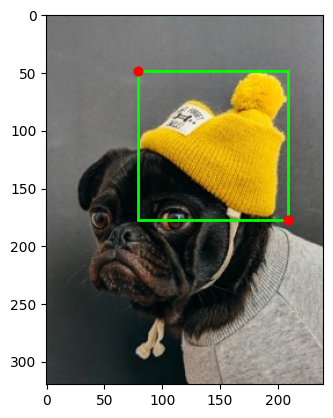

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

im = Image.open('perrito.jpeg')
width, height = im.size

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(Image.fromarray(image_source))

for i, box in enumerate(boxes_xyxy):
    # Create a Rectangle patch
    rect = patches.Rectangle((box[0], box[1]), (box[2]-box[0]), (box[3]-box[1]), linewidth=2, edgecolor='lime', facecolor='none')
    ax.add_patch(rect)
    
    ax.scatter(box[0], box[1], c='red', s=40)
    ax.scatter(box[2], box[3], c='red', s=40)

plt.show()

In [8]:
image_source.shape

(320, 240, 3)

In [9]:
from segment_anything import SamPredictor, sam_model_registry
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)
predictor.set_image(image_source)

In [10]:
image_source.shape

(320, 240, 3)

In [11]:
image_source.shape[:2]

(320, 240)

In [12]:
transformed_boxes = predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2])
masks, _, _ = predictor.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes = transformed_boxes,
            multimask_output = False
        )

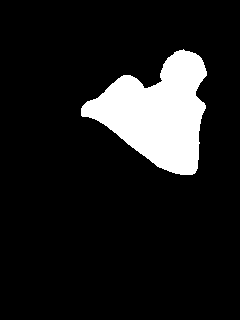

In [13]:
ToPILImage()((masks[0] * 1.0))

In [14]:
def expand_mask(mask, radius):
    t_image = mask.clone()

    t_zeros = torch.zeros_like(t_image)
    for i in range(1, radius):
        cropped_bottom_right = t_image[:, i:, i:]
        t_zeros[:, :-i, :-i] += cropped_bottom_right

        cropped_top_left = t_image[:, :-i, :-i]
        t_zeros[:, i:, i:] += cropped_top_left

        cropped_bottom_left = t_image[:, i:, :-i]
        t_zeros[:, :-i, i:] += cropped_bottom_left

        cropped_top_right = t_image[:, :-i, i:]
        t_zeros[:, i:, :-i] += cropped_top_right

        cropped_top = t_image[:, i:, :]
        t_zeros[:, :-i, :] += cropped_top

        cropped_left = t_image[:, :, i:]
        t_zeros[:, :, :-i] += cropped_left

        cropped_right = t_image[:, :, :-i]
        t_zeros[:, :, i:] += cropped_right

        cropped_bottom = t_image[:, :-i, :]
        t_zeros[:, i:, :] += cropped_bottom

    t_zeros = torch.clamp(t_zeros, 0, 1)
    return t_zeros

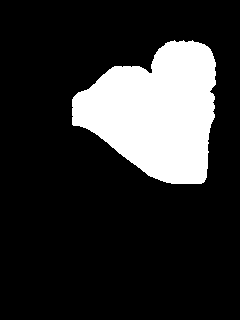

In [15]:
expanded_mask = expand_mask(masks[0] * 1.0, 10)
ToPILImage()(expanded_mask)

In [16]:
masks[0].shape

torch.Size([1, 320, 240])

In [17]:
print(masks[0].permute(1, 2, 0).shape)

torch.Size([320, 240, 1])


In [18]:
random_mask = (torch.randn(3088, 2316, 1) > 0.5) * 1.0

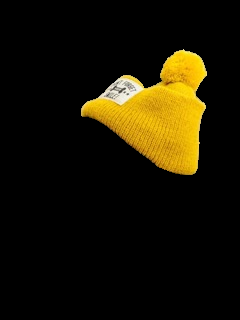

In [19]:
masked_image = torch.Tensor(image_source) * masks[0].permute(1, 2, 0)
# masked_image = torch.Tensor(image_source) * random_mask
ToPILImage()((masked_image / 255).numpy())

In [20]:
image_source.shape

(320, 240, 3)

In [21]:
expanded_mask.permute(1, 2, 0).shape

torch.Size([320, 240, 1])

In [22]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16
)
pipe = pipe.to("mps")

prompt = "A blue hat"
inpainted_image = pipe(prompt=prompt, image=image_source, mask_image=expanded_mask.permute(1, 2, 0)).images[0]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
safety_checker/model.safetensors not found
python(37043) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Loading pipeline components...: 100%|██████████| 7/7 [00:59<00:00,  8.56s/it]


RuntimeError: Invalid buffer size: 20.00 GB

In [ ]:
inpainted_image